In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import os
import gc
import joblib

from PIL import Image
from PIL import ImageDraw
train_on_gpu = True

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,optimizers,models
from keras.metrics import AUC

In [7]:
df_labels = pd.read_csv('C:/Users/ilzep/histopathologic-cancer-detection-data/train_labels.csv')
df_samples = pd.read_csv('C:/Users/ilzep/histopathologic-cancer-detection-data/sample_submission.csv')
train = "C:/Users/ilzep/histopathologic-cancer-detection-data/train/"
test = "C:/Users/ilzep/histopathologic-cancer-detection-data/test"
img_train = os.listdir(train)
img_test = os.listdir(test)

#print(img_test)

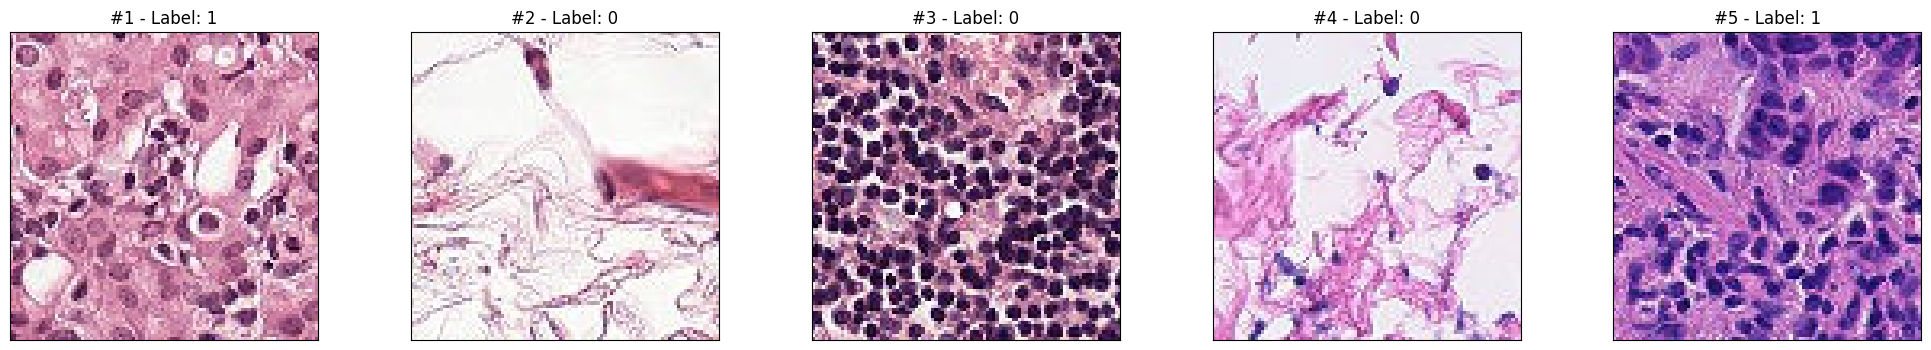

In [6]:
fig = plt.figure(figsize=(25, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(train + img_train[i])
    plt.imshow(im)
    label = df_labels.loc[df_labels['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

In [10]:
train_data, val_data = train_test_split(df_labels, test_size=0.2, random_state=42, stratify=df_labels['label'])

train_data = train_data.astype(str)
val_data = val_data.astype(str)
test_data = df_samples.astype(str)
df_samples.drop('label', axis=1, inplace=True)
test_data = df_samples.astype(str)

train_data['id'] += '.tif'
val_data['id'] += '.tif'
test_data['id'] += '.tif'

In [11]:
datagenerator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = datagenerator.flow_from_dataframe(
    dataframe=train_data,
    directory = train,
    x_col = 'id',
    y_col = 'label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)
val_generator = datagenerator.flow_from_dataframe(
    dataframe=val_data,
    directory = train,
    x_col = 'id',
    y_col = 'label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)
test_generator = datagenerator.flow_from_dataframe(
    dataframe=test_data,
    directory = test,
    x_col = 'id',
    y_col = None,
    target_size = (96, 96),
    class_mode = None,
    shuffle = False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


In [12]:
def CNN(model):
    
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(96,96,3)))
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    # Convert to 1D vector
    model.add(layers.Flatten())

    # Classification layers
    model.add(layers.Dense(64, activatDropoution='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [13]:
cnn_model = CNN(tf.keras.Sequential())
cnn_model.compile(
    optimizer = 'RMSprop',
    loss = 'binary_crossentropy',
    metrics = [AUC()]
)

C:\Users\ilzep\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
RMS_history = cnn_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 5
)

Epoch 1/5


C:\Users\ilzep\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2984s 541ms/step - auc: 0.8562 - loss: 0.4572 - val_auc: 0.9134 - val_loss: 0.3912
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2811s 511ms/step - auc: 0.9120 - loss: 0.3665 - val_auc: 0.9081 - val_loss: 0.5260
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1551s 282ms/step - auc: 0.9246 - loss: 0.3404 - val_auc: 0.9382 - val_loss: 0.3243
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1350s 245ms/step - auc: 0.9317 - loss: 0.3249 - val_auc: 0.9204 - val_loss: 0.4432
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1325s 241ms/step - auc: 0.9372 - loss: 0.3106 - val_auc: 0.9420 - val_loss: 0.3097


In [15]:
prediction_labels = cnn_model.predict(test_generator)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 654s 364ms/step


In [17]:
submit = pd.DataFrame()
submit['id'] = test_data['id'].str.partition('.')[0]
submit['label'] = prediction_labels[:, 0]
submit.to_csv('submit.csv', index = False)

In [20]:

# save model for later use:
#joblib.dump(cnn_model, 'cnn_model.pkl')
cnn_model.save_weights('cnn_model.weights.h5')
with open('cnn_model_architecture.json', 'w') as f:
    f.write(cnn_model.to_json())
# Later, when you want to use the model again
# Load the model from the file
##cnn_model = joblib.load('modelcnn_.pkl')

# Load model architecture from JSON file
#with open('cnn_model_architecture.json', 'r') as f:
#    cnn_model = tf.keras.models.model_from_json(f.read())

# Load model weights
# cnn_model.load_weights('cnn_model_weights.h5')

In [22]:
print(RMS_history.history.keys())

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])


In [23]:
accuracy = pd.DataFrame()
accuracy['loss'] = RMS_history.history['loss']
accuracy['auc'] = RMS_history.history['auc']
accuracy['val_loss'] = RMS_history.history['val_loss']
accuracy['val_auc'] = RMS_history.history['val_auc']
accuracy.to_csv('cnn_accuracy.csv', index = False)

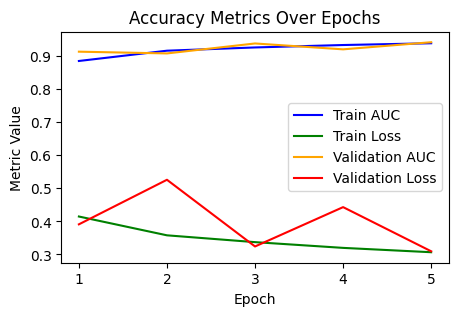

In [27]:
fig, ax = plt.subplots(figsize=(5, 3))

# Plot the accuracy metrics against the epoch
ax.plot(accuracy.index + 1, accuracy['auc'], label='Train AUC', color='blue')
ax.plot(accuracy.index + 1, accuracy['loss'], label='Train Loss', color='green')
ax.plot(accuracy.index + 1, accuracy['val_auc'], label='Validation AUC', color='orange')
ax.plot(accuracy.index + 1, accuracy['val_loss'], label='Validation Loss', color='red')

# Set labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric Value')
ax.set_title('Accuracy Metrics Over Epochs')
plt.xticks(range(1, len(accuracy) + 1))
# Add legend
ax.legend()

# Show plot
plt.show()